In [53]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
# clean the descriptions
import nltk
from nltk.corpus import stopwords # import stopwords 
from string import punctuation # import punctuations
from nltk.corpus import wordnet # to check if a word is english
from nltk.stem import PorterStemmer #Porter stemming algorithm to remove and replace well-known suffixes of English words
# Create the vocabularies
from collections import defaultdict
import math
import json
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy import sparse
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import read_clean as rd
from importlib import reload 
import clustering as cl

In this assignment we will perform a clustering analysis of house announcements in Rome from Immobiliare.it

![alt text](https://directionscu.org/wp-content/uploads/2018/08/cashforhome.png "Logo Title Text 1")

First of all we have to start with the scrapping! The website that we scraped is: [here](https://www.immobiliare.it). In particular, you retrieved at least 10k announcements starting from this [link](https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1).

We did it by using the libraries  *BeautifulSoup* and *requests*

In [ ]:
# create empty dataframe to visualize the results of the query
df_final = pd.DataFrame(columns=["Title", "Price", "Locali", "Superficie", "Bagni", "Piano"])

pag = 1
while len(df_final) < 10000:
    source = requests.get("https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=" + str(pag))
    print(pag)
    soup = BeautifulSoup(source.text, "html.parser") # try also "html.parser"
    df_new_page = read_announcement(soup)
    df_final = pd.concat([df_final, df_new_page], ignore_index=True)
    #print("Pag:", pag, "we have collected:", len(df_final), "elements")
    pag += 1

In [ ]:
# to build the dataframe it takes 15/20 min for this reasone we save it in a csv file
df_final.to_csv('announcement.csv', index = False)

In [5]:
del(df_final)

In [13]:
data = pd.read_csv("announcement.csv")
data.head(10)

,Bagni,Description URL,Locali,Piano,Price,Superficie,Title
0,1,https://www.immobiliare.it/53131931-Vendita-Bi...,2,1,225000,50.0,"Bilocale viale Italo Calvino, Fonte Ostiense, ..."
1,1,https://www.immobiliare.it/70085240-Vendita-Tr...,3,3,400000,60.0,"Trilocale piazza San Giovanni di Dio 39, Monte..."
2,2,https://www.immobiliare.it/70084602-Vendita-Tr...,3,3,500000,89.0,"Trilocale piazza San Giovanni di Dio 39, Monte..."
3,2,https://www.immobiliare.it/70100018-Vendita-Qu...,4,5,574000,89.0,"Quadrilocale piazza San Giovanni di Dio 39, Mo..."
4,1,https://www.immobiliare.it/70085670-Vendita-Bi...,2,4,300000,46.0,"Bilocale piazza San Giovanni di Dio 39, Montev..."
5,2,https://www.immobiliare.it/70085950-Vendita-Tr...,3,4,425000,72.0,"Trilocale piazza San Giovanni di Dio, Montever..."
6,2,https://www.immobiliare.it/70086882-Vendita-Ap...,5,4,669000,86.0,"Appartamento piazza San Giovanni di Dio 39, Mo..."
7,2,https://www.immobiliare.it/70100304-Vendita-At...,5,5,657000,87.0,Attico / Mansarda piazza San Giovanni di Dio 3...
8,1,https://www.immobiliare.it/53973750-Vendita-Tr...,3,1,257000,61.0,"Trilocale via Maso Finiguerra 27C-D, Romanina,..."
9,1,https://www.immobiliare.it/70082804-Vendita-Bi...,2,3,325000,60.0,"Bilocale piazza San Giovanni di Dio 39, Montev..."


## Clean Function

In [14]:
nltk.download('wordnet') # download the italian words
nltk.download('omw')
nltk.download("stopwords") # download the stopwords

# create a set of english stopwords and punctuations 
stop_words = set(stopwords.words('italian')+list(punctuation)) 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mvice\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\mvice\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mvice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read all the descriptions, clean and save them

In [ ]:
for ind, url in enumerate(data["Description URL"]):
    source_descr = requests.get(url)
    soup_descr = BeautifulSoup(source_descr.text, "html.parser")
    div_descr = soup_descr.find_all("div", {"class" : "col-xs-12 description-text text-compressed"})
    
    if list(div_descr) == []:
        print(ind)
        file = open("description_documents/doc_" + str(ind) + ".txt", "w", encoding="utf8")
        file.write("")
        file.close()
        continue
    else:
        descr = rd.cleaning_function(div_descr[0].div.text)
        file = open("description_documents/doc_" + str(ind) + ".txt", "w", encoding="utf8")
        file.write(descr)
        file.close()

## Create the vocabularies

map_id_term = {"word0" : term_id_0, "word1": term_id_1 , "word2":term_id_2,....}

map_term_ID = { term_id_0 : "word0",  term_id_1 : "word1", term_id_2 : "word2", ... } 

vocabulary = { term_id : [document_id_0, document_id_1, document_id_2, ... ], ... }

Example:

map_id_term ={"case" : 0, "palazzo": 1 , "terrazzo":2,...} 

map_term_ID = { 0 : "casa", 1 : "palazzo", 2 : "terrazzo", ... }

vocabulary = { 0 : [23, 348, 873, 1239, ...], 1 : [738, 948, 6235], ... }

In [20]:
# give an id to each word
map_id_term = {}
# initialize a default dictionary to store which documents contain a specific word
vocabulary =  defaultdict(list)
problems=[]
numb_words = 0
for j in range(0,10000):
    if j % 1000 == 0:
        print(j)
    # open each tsv file
    try:
        with open("description_documents/doc_" + str(j) + ".txt" , encoding="utf8", mode='r') as txtfile:
            # is the csv reader where we specify the separator/delimeter
            new_file = txtfile.read()
            # i create a list with all the word separated of the Title and the Description
            list_of_words = new_file.split(" ") # maybe could be row1[0].split(" ")
            # for each word in this list i append the number of the document that contain this word
            for word in list_of_words:
                '''if word.isdigit():
                    continue
                else:'''
                if word not in map_id_term.keys():
                    map_id_term[word] = numb_words
                    numb_words += 1

                if j not in vocabulary[map_id_term[word]]:
                    vocabulary[map_id_term[word]].append(j)
    except:
        problems.append(j)
with open('map_id_term.json', 'w') as outfile:
    json.dump(map_id_term, outfile)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [4]:
map_term_ID={}
for i in map_id_term:
    map_term_ID[map_id_term[i]]=i
with open('map_term_ID.json', 'w') as outfile:
    json.dump(map_term_ID, outfile)

In [6]:
with open('vocabulary.json') as json_data:
    vocabulary= json.load(json_data)

In [7]:
# initialize a dictonary where the keys are the ID_announcments
vocabulary_tfidf = {}
for i in range(10000):
    try:
        file = open("description_documents/doc_" + str(i) + ".txt", mode='r', encoding = "utf8")
        document=file.read()
        list_of_words = document.split()
        for word in list_of_words:
            if word.isdigit():
                continue
            else:
                idx_word=map_id_term[word]
                value_tf_idf=rd.tf_idf(word,list_of_words,len(vocabulary[str(idx_word)]))
                v=tuple((idx_word,round(value_tf_idf,4)))
            if i in vocabulary_tfidf:
                vocabulary_tfidf[i].append(v)
            else:
                vocabulary_tfidf[i]=[v]
    except:
        problems.append(i)
with open('vocabulary_tfidf.json', 'w') as outfile:
    json.dump(vocabulary_tfidf, outfile)

## CLUSTERING


To compute the clusters, we have to implement algorithms to creates two matrices. The first matrix will represent the information about bagni, locali, superifice, piano and Price; the second one, instead, will have *announcemnt_id* for the rows, *word_id* for the columns, and it will represent the *tf_idf*

First of all, we have to build a new matrix from the first DataFrame, we have to clean it because we discovered some strange values inside the columns *Piano, Bagni, Locaci, Superficie* such as *Ammezzato, Interrato* and so for. We convert this information to an  integer with the functions those are in *py* file called **clustering**:

In [25]:
df=pd.read_csv('announcement.csv')

In [26]:
df['Locali']=df['Locali'].apply(cl.clean_locali)
df['Piano']=df['Piano'].apply(cl.clean_piano)
df['Superficie']=df['Superficie'].apply(cl.clean_superficie)
df['Price']=df['Price'].apply(cl.clean_Price)

Now we create a new DataFrame, so to have only the columns we need

In [27]:
df2=pd.DataFrame()
df2['Bagni']=df['Bagni']
df2['Locali']=df['Locali']
df2['Piano']=df['Piano']
df2['Superficie']=df['Superficie']
df2['Price']=df['Price']

The first matrix will have this format: <img src="https://latex.codecogs.com/gif.latex?$m_{ij}&space;=&space;value$" title="$m_{ij} = value$" /> where <img src="https://latex.codecogs.com/gif.latex?$i&space;\in&space;\{announcement_1,&space;...,&space;announcement_n\}$" title="$i \in \{announcement_1, ..., announcement_n\}$" /> and <img src="https://latex.codecogs.com/gif.latex?$j&space;\in&space;\{price,&space;locali,&space;superficie,&space;bagni,&space;piano&space;\}$" title="$j \in \{price, locali, superficie, bagni, piano \}$" />. *n* is the number of the announcements.


In [28]:
#trasforming DataFrame to Numpy array
K=df2.values

Now we can start computing **Elbow Method** for the first Matrix.

The Elbow method is a consistency interpretation and validation method within cluster analysis, designed to help find the appropriate number of clusters in a dataset.

We used the library *KMeans* from *sklearn.cluster*. 

In [14]:
sd = {}
for k in range(1, 11):
    model = KMeans(k, init='k-means++')
    model.fit(K)
    # Getting the sum of squared distances of samples to closest cluster center
    sd[k] = model.inertia_
with open('sd.json', 'w') as outfile:
    json.dump(sd, outfile)

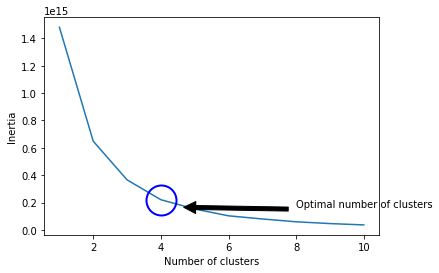

In [15]:
x = list(sd.keys())
y = list(sd.values())
fig = plt.figure()
plt.plot(x,y)
#we find out the best number of clusters
plt.plot(x[3], y[3], 'o', ms=30, mec='b', mfc='none', mew=2)
#adding a edges
plt.annotate('Optimal number of clusters', 
             xy=(4.5,166000000000000), xytext=(8,166000000000000),
             arrowprops = dict(facecolor='black', shrink=0.05))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()
fig.savefig("optimal-clusters.png")

Thanks to this plot we discover the number of clusters we have to use, n=4. We can now start to analyze the clusters.

In [16]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(K)


In [17]:
M=kmeans.labels_

We create a dictonary to represent in which cluster the appartment ID is


In [18]:
cluster_distribution={1:[],2:[],3:[],4:[]}
for i in range(len(M)):
    cluster_distribution[M[i]+1].append(i)
with open('cluster_distribution.json', 'w') as outfile:
    json.dump(cluster_distribution, outfile)

Now, form the description docs, we create the second Matrix.

The second matrix will have this format: <img src="https://latex.codecogs.com/gif.latex?$m_{ij}&space;=&space;tfIdf_{ij}$" title="$m_{ij} = tfIdf_{ij}$" /> where <img src="https://latex.codecogs.com/gif.latex?$i&space;\in&space;\{announcement_1,&space;...,&space;announcement_n\}$" title="$i \in \{announcement_1, ..., announcement_n\}$" /> and <img src="https://latex.codecogs.com/gif.latex?$j&space;\in&space;\{word_1,&space;...,word_m\}$" title="$j \in \{word_1, ...,word_m\}$"/> 

<b>n</b> is the number of announcements and <b>m</b> is the cardinality of the vocabulary.

In [4]:
#downloading the json file about the dictonary related to descriptions
with open('vocabulary_tfidf.json') as json_data:
    vocabulary_tfidf= json.load(json_data)
with open('vocabulary.json') as json_data:
    vocabulary= json.load(json_data)

In [5]:
#We use Numpy: we start we a zeros array
M=np.zeros((10000,len(vocabulary)))
#filling the matrix with the tf_idf values
for i in vocabulary_tfidf:
    for j in vocabulary_tfidf[i]:
        v=j[0]
        T=j[1]
        M[int(i)][v]=T

THANKS TO THE LIBRARY SPICY, WE MANAGE TO HAVE A *SPARSE* MATRIX, THIS ALLOWS TO MAKE FASTER ALGORITHMS FOR THE **ELBOW METHOD**

In [6]:
sM = sparse.csr_matrix(M) 

In [7]:
model = KMeans(sM, init='k-means++')

In [8]:
sd2 = {}
for k in range(1, 21):
    model = KMeans(k, init='k-means++')
    model.fit(sM)
    # Getting the sum of squared distances of samples to closest cluster center
    sd2[k] = model.inertia_
with open('sd2.json', 'w') as outfile:
    json.dump(sd2, outfile)
V1=[]
for i in sd2:
    V1.append(sd2[i])
with open('V.json', 'w') as outfile:
    json.dump(V1, outfile)

In [9]:
with open('V.json') as json_data:
    V1= json.load(json_data)

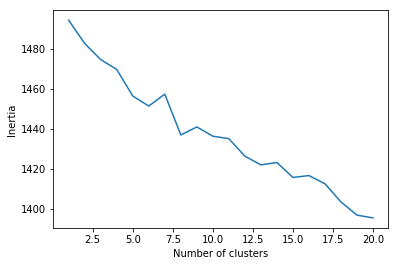

In [24]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y = V1
fig = plt.figure()
plt.plot(x,y)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

As we can easily see from the plot we can't apply Elbow Method. We decided to use the number of clusters we found out from the matrix before. We did this because we suppose the two matrices are strictly correlated.


In [25]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(sM)

In [26]:
M2=kmeans.labels_

In [27]:
cluster_distribution1={1:[],2:[],3:[],4:[]}
for i in range(len(M2)):
    cluster_distribution1[M2[i]+1].append(i)
with open('cluster_distribution1.json', 'w') as outfile:
    json.dump(cluster_distribution1, outfile)

Now we have to compute **Jaccard** similarity to discover if the result between these two clusters are collerated or not.

J(A,B) = ∣A ∩ B∣ / ∣A∣ + ∣B∣ - ∣A ∩ B|

In [28]:
with open('cluster_distribution.json') as json_data:
    cluster_distribution= json.load(json_data)
with open('cluster_distribution1.json') as json_data:
    cluster_distribution1= json.load(json_data)

In [31]:
df3=pd.DataFrame(index=range(1,5), columns=range(1,5))
for i in range(1,5):
    for j in range(1,5):
        df3[i][j]=cl.jaccard_similarity(cluster_distribution[str(i)], cluster_distribution1[str(j)])
df3

,1,2,3,4
1,0.24,0.05,0.01,0.6
2,0,0.01,0,0
3,0.07,0.04,0.01,0.11
4,0.05,0.02,0.01,0.06


We see immediately that we have some as faint similarities. The most similar couple of clusters are: (1;1),(3;4),(3;1).

In [32]:
with open('vocabulary_tfidf.json') as json_data:
    vocabulary_tfidf= json.load(json_data)

In [33]:
with open('vocabulary.json') as json_data:
    vocabulary= json.load(json_data)

In [34]:
with open('map_term_ID.json') as json_data:
    map_term_ID= json.load(json_data)

With this last output, we created a [wordcloud](https://www.datacamp.com/community/tutorials/wordcloud-python) for each couple of clusters. The words that will be represented are those extracted from the description of the houses that are in the relative couple.

In [35]:
mask = np.array(Image.open("images.png"))
transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
for i in range(len(mask)):
    transformed_mask[i] = list(map(cl.transform_format, mask[i]))

In [36]:
def crete_WordCloud(cluster1,cluster2): 
    h1=cl.get_id_word(cluster1)
    h2=cl.get_id_word(cluster2)
    s1=cl.fromID_toSTR(h1)
    s2=cl.fromID_toSTR(h2)
    stot=s1+' '+s2
    wordcloud = WordCloud(background_color='white', mask=transformed_mask).generate(stot)
    #image_colors = ImageColorGenerator(transformed_mask)
    plt.figure(figsize=[6,6])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return

**WORDCLOUD** FOR CLUSTER 1 =(1,1)

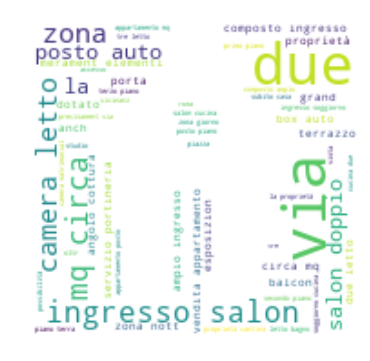

In [37]:
cluster1=cluster_distribution[str(1)]
cluster2=cluster_distribution1[str(1)]
crete_WordCloud(cluster1,cluster2)

**WORDCLOUD** FOR CLUSTER 2 =(3,4)

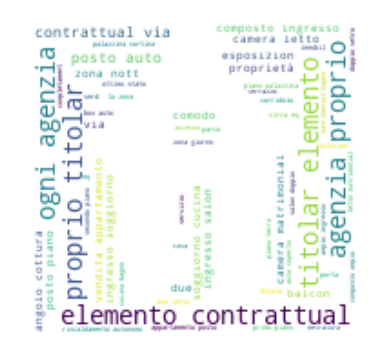

In [185]:
cluster1=cluster_distribution[str(3)]
cluster2=cluster_distribution1[str(4)]
crete_WordCloud(cluster1,cluster2)

**WORDCLOUD** FOR CLUSTER 3 =(3,4)

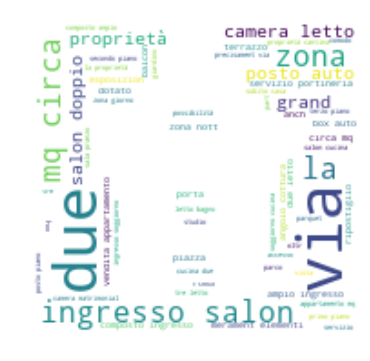

In [186]:
cluster1=cluster_distribution[str(3)]
cluster2=cluster_distribution1[str(1)]
crete_WordCloud(cluster1,cluster2)

## FIRST BONUS

We implemented the K_Means algorithms by our self. (*We were quite lucky because we have already implement this algorithm during FDS*)

In [60]:
import numpy as np

class KMeans:

        def updateClusters(self):
            clus = {i : [] for i in range(self.k)}
            for i in range(self.m):
                dist = np.sum((self.X[i] - self.centroids)**2, axis=1)
                clus[np.argmin(dist)] += [i]
            self.clustering = clus

        def updateCentroids(self):
            for i in range(self.k):
                self.centroids[i] = np.mean(self.X[self.clustering[i]], axis=0)

        def __init__(self, X, k, max_itr=100):
            self.X, self.k = X, k
            self.m, self.d = X.shape
            self.centroids = X[np.random.choice(self.m, k, replace=False)]
            self.iter = 0
            while True:
                self.updateClusters()
                oldCentroids = self.centroids.copy()
                self.updateCentroids()
                self.iter += 1
                if (self.centroids == oldCentroids).all() or self.iter >= max_itr:
                    break

In [72]:
K=K.astype(int)
C=KMeans(K,4)
new_cluster1=C.clustering
#We need to change the key
new_cluster={}
for i in range(1,5):
    new_cluster[i]=new_cluster1[i-1]

In [73]:
with open('cluster_distribution.json') as json_data:
    cluster_distribution= json.load(json_data)

In [74]:
df3=pd.DataFrame(index=range(1,5), columns=range(1,5))
for i in range(1,5):
    for j in range(1,5):
        df3[i][j]=cl.jaccard_similarity(cluster_distribution[str(i)], new_cluster[j])
df3

,1,2,3,4
1,0.09,0.06,0,0.34
2,0.17,0.06,0.01,0.21
3,0.15,0.02,0.01,0.17
4,0.17,0.05,0,0.19


We found some similarity between the results. the similarity is not very strong because these methods are pretty different, indeed **k-means++** is more accurate, so it gives us a better return.